# OCR 수행

In [2]:
!pip install keras_ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 8.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.5/971.5 kB 8.5 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.9 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [23]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.15.0
1.26.2
10.1.0
4.9.0
0.9.3


In [24]:
import os

path = "/tf/aiffel"
os.chdir(path)
print(path)

/tf/aiffel


In [25]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [26]:
!pip install lmdb


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = path +"/data_lmdb_release/data_lmdb_release/data_lmdb_release/training"

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/tf/aiffel/data_lmdb_release/data_lmdb_release/data_lmdb_release/training/MJ/MJ_train


# EDA

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


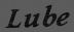

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


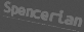

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


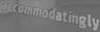

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


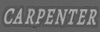

In [28]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [29]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


# Encode , Decode

In [30]:

class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [31]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# CTC Loass

In [32]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


# CRNN 모델 설계

In [33]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


# 훈련

In [34]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

2024-01-23 16:08:23.675086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 16:08:23.680837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 16:08:23.682604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


Epoch 1/20
565/565 [==============================] - 21s 37ms/step - loss: 25.8579 - val_loss: 25.9398
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 25.7587 - val_loss: 25.8678
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 25.6742 - val_loss: 25.7795
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 25.6009 - val_loss: 25.7271
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 25.5347 - val_loss: 25.6524
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 25.4761 - val_loss: 25.6758
Epoch 7/20
565/565 [==============================] - 21s 37ms/step - loss: 25.4221 - val_loss: 25.5540
Epoch 8/20
565/565 [==============================] - 21s 37ms/step - loss: 25.3717 - val_loss: 25.4876
Epoch 9/20
565/565 [==============================] - 21s 37ms/step - loss: 25.3232 - val_loss: 25.5048
Epoch 10/20
565/565 [==============================] - 21s 37ms/

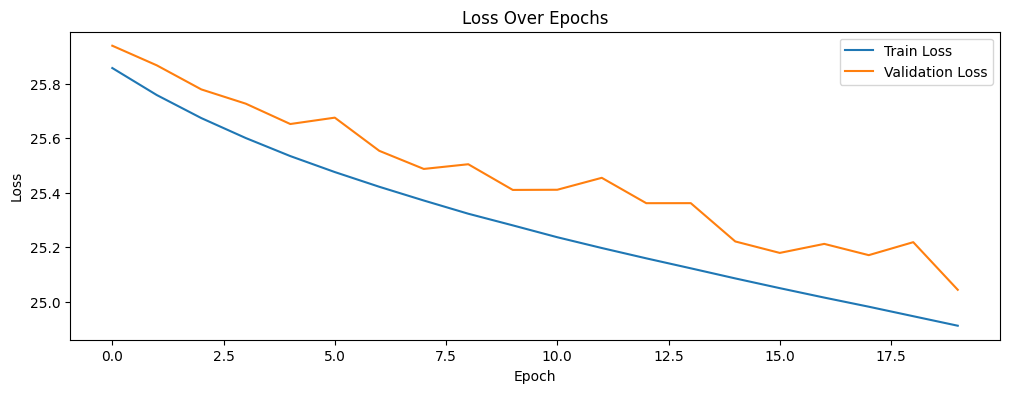

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    # 학습 과정에서의 손실 값
    plt.figure(figsize=(12, 4))
    
    # plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch2_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history2 = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


Epoch 1/20
565/565 [==============================] - 21s 37ms/step - loss: 24.8775 - val_loss: 25.0344
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 24.8414 - val_loss: 24.9871
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 24.8071 - val_loss: 24.9601
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 24.7736 - val_loss: 24.9608
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 24.7359 - val_loss: 24.9196
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 24.7008 - val_loss: 24.8740
Epoch 7/20
565/565 [==============================] - 21s 37ms/step - loss: 24.6641 - val_loss: 24.8146
Epoch 8/20
565/565 [==============================] - 21s 37ms/step - loss: 24.6294 - val_loss: 24.7820
Epoch 9/20
565/565 [==============================] - 21s 37ms/step - loss: 24.5914 - val_loss: 24.7708
Epoch 10/20
565/565 [==============================] - 21s 37ms/

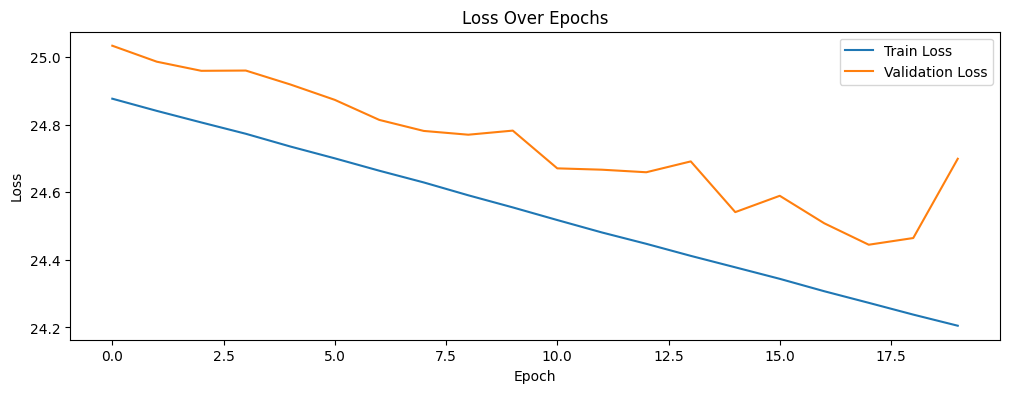

In [19]:

plot_history(history2)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch3_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history2 = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


Epoch 1/20
565/565 [==============================] - 21s 37ms/step - loss: 24.1709 - val_loss: 24.3613
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 24.1367 - val_loss: 24.3876
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 24.1033 - val_loss: 24.3767
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 24.0697 - val_loss: 24.3171
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 24.0375 - val_loss: 24.2261
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 24.0044 - val_loss: 24.2661
Epoch 7/20
565/565 [==============================] - 21s 37ms/step - loss: 23.9722 - val_loss: 24.1504
Epoch 8/20
565/565 [==============================] - 21s 37ms/step - loss: 23.9395 - val_loss: 24.1826
Epoch 9/20
565/565 [==============================] - 21s 37ms/step - loss: 23.9058 - val_loss: 24.1029
Epoch 10/20
565/565 [==============================] - 21s 37ms/

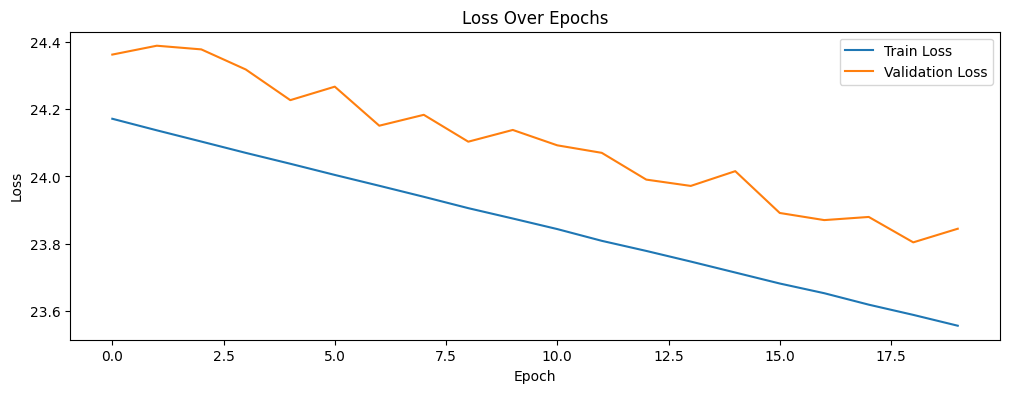

In [21]:

plot_history(history2)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch4_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history4 = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


Epoch 1/20
565/565 [==============================] - 21s 37ms/step - loss: 23.5268 - val_loss: 23.7563
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 23.4919 - val_loss: 23.7141
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 23.4628 - val_loss: 23.7204
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 23.4317 - val_loss: 23.7011
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 23.4015 - val_loss: 23.6850
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 23.3703 - val_loss: 23.5995
Epoch 7/20
565/565 [==============================] - 21s 37ms/step - loss: 23.3379 - val_loss: 23.5639
Epoch 8/20
565/565 [==============================] - 21s 37ms/step - loss: 23.3078 - val_loss: 23.5475
Epoch 9/20
565/565 [==============================] - 21s 37ms/step - loss: 23.2775 - val_loss: 23.5378
Epoch 10/20
565/565 [==============================] - 21s 37ms/

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch4_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history4 = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


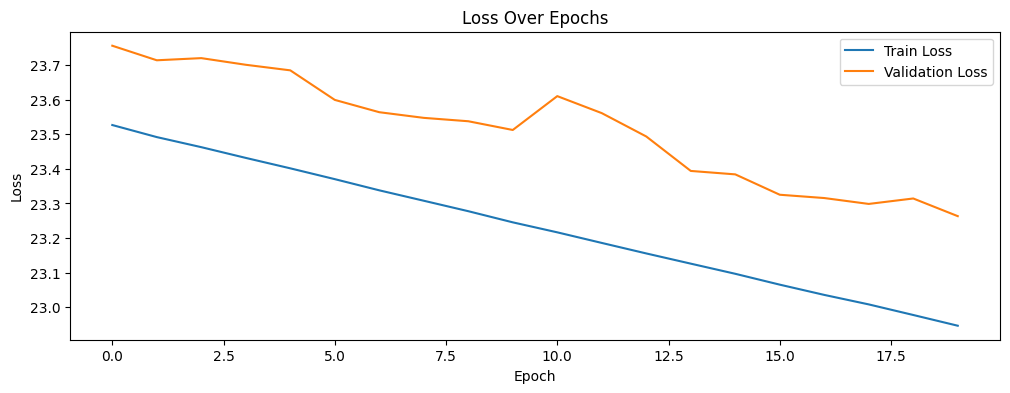

In [23]:

plot_history(history4)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 파일 이름에 에폭 번호만 포함
checkpoint_filepath = HOME_DIR + '/MJ/model_checkpoint_epoch5_{epoch:02d}.hdf5'

# ModelCheckPoint 설정: 매 에폭마다 'val_loss'를 모니터링하고, 가중치만 저장
ckp = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience=5)  # patience는 조정 가능

# 모델 훈련
history5 = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=20,  # epochs를 1로 설정했으나 필요에 따라 조정 가능
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop]  # 콜백 사용
)


Epoch 1/20
565/565 [==============================] - 21s 37ms/step - loss: 22.9191 - val_loss: 23.2176
Epoch 2/20
565/565 [==============================] - 21s 37ms/step - loss: 22.8886 - val_loss: 23.1733
Epoch 3/20
565/565 [==============================] - 21s 37ms/step - loss: 22.8608 - val_loss: 23.2368
Epoch 4/20
565/565 [==============================] - 21s 37ms/step - loss: 22.8297 - val_loss: 23.1951
Epoch 5/20
565/565 [==============================] - 21s 37ms/step - loss: 22.8010 - val_loss: 23.0895
Epoch 6/20
565/565 [==============================] - 21s 37ms/step - loss: 22.7711 - val_loss: 23.2361
Epoch 7/20
565/565 [==============================] - 21s 37ms/step - loss: 22.7443 - val_loss: 23.0612
Epoch 8/20
565/565 [==============================] - 21s 37ms/step - loss: 22.7158 - val_loss: 23.1504
Epoch 9/20
565/565 [==============================] - 21s 37ms/step - loss: 22.6858 - val_loss: 23.0470
Epoch 10/20
565/565 [==============================] - 21s 37ms/

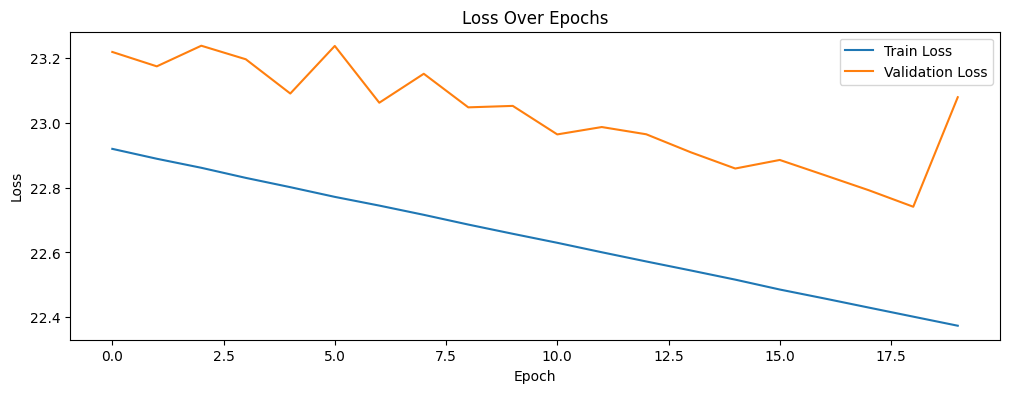

In [25]:

plot_history(history5)

In [26]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint_epoch5_19.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [43]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    text = text.rstrip("9")
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

1/1 [==============================] - 1s 831ms/step
Result: 	 CAEIS


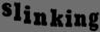

1/1 [==============================] - 0s 17ms/step
Result: 	 CSES


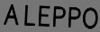

1/1 [==============================] - 0s 17ms/step
Result: 	 CAES


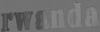

1/1 [==============================] - 0s 17ms/step
Result: 	 CAOIS


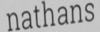

1/1 [==============================] - 0s 17ms/step
Result: 	 BA


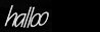

1/1 [==============================] - 0s 17ms/step
Result: 	 CS


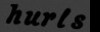

1/1 [==============================] - 0s 17ms/step
Result: 	 CAOES


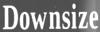

1/1 [==============================] - 0s 17ms/step
Result: 	 CAI


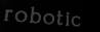

1/1 [==============================] - 0s 17ms/step
Result: 	 CAI


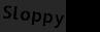

1/1 [==============================] - 0s 17ms/step
Result: 	 CSRERS


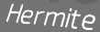

In [44]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint_epoch_20.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)
check_inference(model_pred, test_set, index=10)

1/1 [==============================] - 1s 1s/step
Result: 	 SALIE9999999999999999999


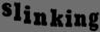

1/1 [==============================] - 0s 18ms/step
Result: 	 SBAES9999999999999999999


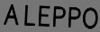

1/1 [==============================] - 0s 17ms/step
Result: 	 SRE999999999999999999999


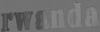

1/1 [==============================] - 0s 17ms/step
Result: 	 CBIAIES99999999999999999


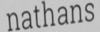

1/1 [==============================] - 0s 18ms/step
Result: 	 BAL999999999999999999999


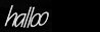

1/1 [==============================] - 0s 17ms/step
Result: 	 CPA999999999999999999999


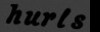

1/1 [==============================] - 0s 17ms/step
Result: 	 CMONRE999999999999999999


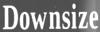

1/1 [==============================] - 0s 17ms/step
Result: 	 CPARIS999999999999999999


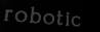

1/1 [==============================] - 0s 17ms/step
Result: 	 SAI999999999999999999999


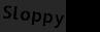

1/1 [==============================] - 0s 17ms/step
Result: 	 CPRERIES9999999999999999


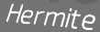

In [37]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint_epoch3_19.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)
check_inference(model_pred, test_set, index=10)

1/1 [==============================] - 1s 773ms/step
Result: 	 SCALIN999999999999999999


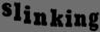

1/1 [==============================] - 0s 17ms/step
Result: 	 BAED99999999999999999999


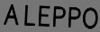

1/1 [==============================] - 0s 17ms/step
Result: 	 SCRAY9999999999999999999


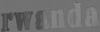

1/1 [==============================] - 0s 18ms/step
Result: 	 SBAIS9999999999999999999


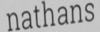

1/1 [==============================] - 0s 25ms/step
Result: 	 BDAL99999999999999999999


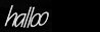

1/1 [==============================] - 0s 17ms/step
Result: 	 CPO999999999999999999999


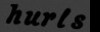

1/1 [==============================] - 0s 18ms/step
Result: 	 CMONIE999999999999999999


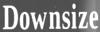

1/1 [==============================] - 0s 19ms/step
Result: 	 CPAOS9999999999999999999


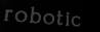

1/1 [==============================] - 0s 17ms/step
Result: 	 SAI999999999999999999999


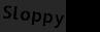

1/1 [==============================] - 0s 17ms/step
Result: 	 CPERIES99999999999999999


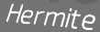

In [38]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint_epoch5_19.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)
check_inference(model_pred, test_set, index=10)

1/1 [==============================] - 1s 1s/step
Result: 	 SLINKING9999999999999999


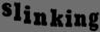

1/1 [==============================] - 0s 17ms/step
Result: 	 ALEPPO99999999999999999


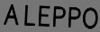

1/1 [==============================] - 0s 17ms/step
Result: 	 FWANDA999999999999999999


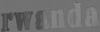

1/1 [==============================] - 0s 17ms/step
Result: 	 NATHANS99999999999999999


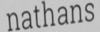

1/1 [==============================] - 0s 17ms/step
Result: 	 HALE99999999999999999999


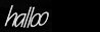

1/1 [==============================] - 0s 17ms/step
Result: 	 HURLS9999999999999999999


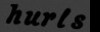

1/1 [==============================] - 0s 17ms/step
Result: 	 DOWNSIZE9999999999999999


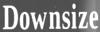

1/1 [==============================] - 0s 18ms/step
Result: 	 ROBOTIC99999999999999999


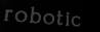

1/1 [==============================] - 0s 17ms/step
Result: 	 SLOPPY99999999999999999


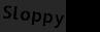

1/1 [==============================] - 0s 17ms/step
Result: 	 SHERMITE9999999999999999


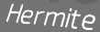

In [20]:

# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)
check_inference(model_pred, test_set, index=10)

In [22]:
import keras_ocr
import numpy as np
from PIL import Image, ImageDraw

def detect_text(img_path):
    # keras-ocr detector 로드
    detector = keras_ocr.detection.Detector()

    # 이미지 로드 및 전처리
    img_pil = Image.open(img_path)
    img_array = np.array(img_pil)
    images = [img_array]

    # 텍스트 감지
    ocr_result = detector.detect(images=images)[0]  # 첫 번째 이미지에 대한 결과

    # 시각화 준비
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []
    for text_result in ocr_result:
        # 감지된 텍스트 주변에 붉은색 사각형 그리기
        img_draw.polygon(text_result, outline='red')
        # 좌표 계산 및 이미지 자르기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs


Looking for /root/.keras-ocr/craft_mlt_25k.h5
1/1 [==============================] - 4s 4s/step


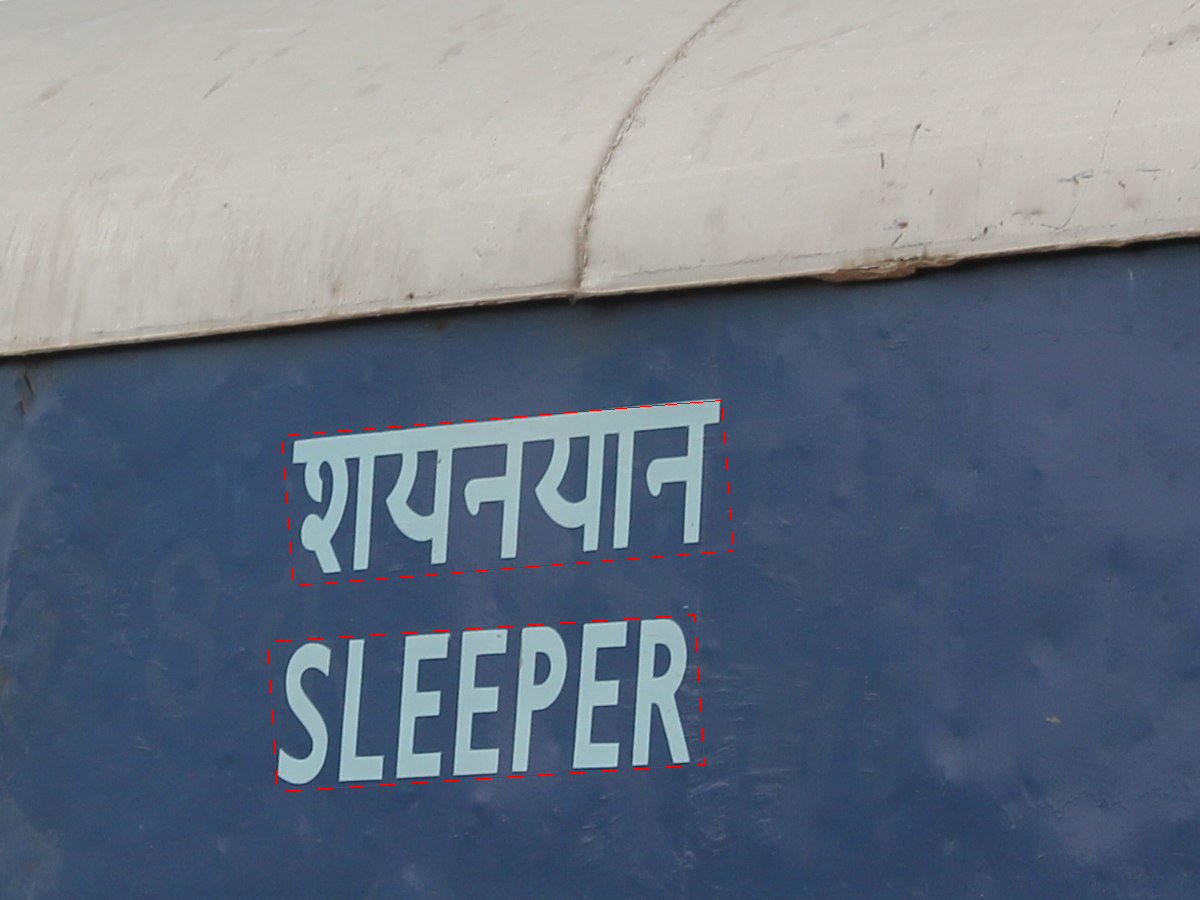

In [26]:

img_pil, cropped_img = detect_text(HOME_DIR +"/sample.jpg")
display(img_pil)

In [34]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # keras-ocr recognizer 로드
    recognizer = keras_ocr.recognition.Recognizer()

    # 이미지 크기가 너무 작은 경우 예외 처리
    if pil_img.size[0] < input_img_size[0] or pil_img.size[1] < input_img_size[1]:
        print("Image size is too small.")
        return ""

    # 이미지 채널 확인 및 조정
    if pil_img.mode != 'RGB':
        pil_img = pil_img.convert('RGB')

    # 이미지를 모델 입력 크기로 조정
    pil_img = pil_img.resize(input_img_size)

    # PIL 이미지를 배열로 변환
    img_array = np.array(pil_img)

    # 텍스트 인식 수행
    recognized_text = recognizer.recognize(img_array)  # 이미지 리스트를 입력으로 제공

    return recognized_text

# 이미지 리스트 처리
recognized_texts = []
for _img in cropped_img:
    text = recognize_img(_img)
    recognized_texts.append(text)


Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


In [35]:
recognized_texts

['tttt', 'sleeper']

In [36]:
def perform_ocr_with_custom_functions(image_path):
    # 텍스트 영역 감지
    detected_image, cropped_images = detect_text(image_path)

    # 각 영역에 대한 텍스트 인식
    recognized_texts = []
    for cropped_image in cropped_images:
        recognized_text = recognize_img(cropped_image)
        recognized_texts.append(recognized_text)

    return recognized_texts

# 함수 사용 예시
image_path = HOME_DIR +"/sample.jpg" # 이미지 경로 설정
ocr_results = perform_ocr_with_custom_functions(image_path)
print(ocr_results)


Looking for /root/.keras-ocr/craft_mlt_25k.h5


1/1 [==============================] - 0s 375ms/step
Looking for /root/.keras-ocr/crnn_kurapan.h5


1/1 [==============================] - 1s 1s/step
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
['tttt', 'sleeper']


# pytesseract OCR

In [42]:
# 혹은 터미널에서 !를 제거 후 실행하도록 합니다
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev
! pip install pytesseract

/bin/bash: line 1: sudo: command not found
/bin/bash: line 1: sudo: command not found

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [57]:
import pytesseract
from pytesseract import Output

In [52]:
from PIL import Image

img = Image.open(image_path)
ocr_result =pytesseract.image_to_string(img)
cleaned_result = ocr_result.strip().replace('\x0c', '')
print(cleaned_result)

waa
ad


In [50]:
! apt install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [39]:
!pip install --upgrade google-cloud-vision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.1/442.1 kB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 9.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.59.3
    Uninstalling grpcio-1.59.3:
      Successfully uninstalled grpcio-1.59.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.2 wh

# GCP OCR 

In [7]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print("Texts:")

    for text in texts:
        print(f'\n"{text.description}"')

        vertices = [
            f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
        ]

        print("bounds: {}".format(",".join(vertices)))

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )


In [20]:
import os

# 환경 변수 설정
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/tf/aiffel/aiffel-412021-f54bd6092a75.json'
# 환경 변수 확인
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])


/tf/aiffel/aiffel-412021-f54bd6092a75.json


In [21]:
text =detect_text(HOME_DIR +"/sample.jpg")

Texts:

"शयनयान
SLEEPER"
bounds: (248,393),(731,393),(731,779),(248,779)

"शयनयान"
bounds: (297,428),(702,393),(714,537),(309,571)

"SLEEPER"
bounds: (266,643),(694,611),(704,745),(276,777)


2024-01-23 16:10:18.760067: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


1/1 [==============================] - 1s 1s/step
Result: 	 CAEIS9999999999999999999


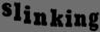

1/1 [==============================] - 0s 18ms/step
Result: 	 CSES99999999999999999999


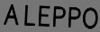

1/1 [==============================] - 0s 17ms/step
Result: 	 CAES99999999999999999999


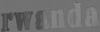

1/1 [==============================] - 0s 18ms/step
Result: 	 CAOIS9999999999999999999


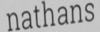

1/1 [==============================] - 0s 16ms/step
Result: 	 BA9999999999999999999999


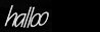

1/1 [==============================] - 0s 17ms/step
Result: 	 CS9999999999999999999999


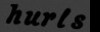

1/1 [==============================] - 0s 17ms/step
Result: 	 CAOES9999999999999999999


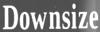

1/1 [==============================] - 0s 17ms/step
Result: 	 CAI999999999999999999999


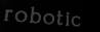

1/1 [==============================] - 0s 17ms/step
Result: 	 CAI999999999999999999999


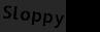

1/1 [==============================] - 0s 17ms/step
Result: 	 CSRERS999999999999999999


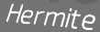

In [37]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint_epoch_20.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)
check_inference(model_pred, test_set, index=10)

#  keras_ocr + CRNN

In [55]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint.hdf5'

from keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image, target_size):
    # 이미지를 모델의 입력 크기로 조정
    # target_size를 (width, height) 순서로 변경
    image = image.resize((target_size[0], target_size[1]))
    image = img_to_array(image).transpose((1, 0, 2))
    image = np.expand_dims(image, axis=0)
    return image

def build_end_to_end_ocr(detector, recognizer, img_path, target_size=(100, 32)):
    # 이미지 로드 및 전처리
    img_pil = Image.open(img_path)
    img_array = np.array(img_pil)
    images = [img_array]

    # 텍스트 감지
    ocr_result = detector.detect(images=images)[0]

    # 인식된 텍스트 영역에서 텍스트 인식
    recognized_texts = []
    for text_result in ocr_result:
        # 좌표 계산 및 이미지 자르기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_img = img_pil.crop(word_box)

        # 이미지 전처리 및 크기 조정
        processed_img = preprocess_image(cropped_img, target_size)

        # CRNN 모델을 사용하여 텍스트 인식
        recognized_text = recognizer.predict(processed_img)
        result = decode_predict_ctc(recognized_text, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        recognized_texts.append(result)

    return recognized_texts
# Detector와 Recognizer 모델 로드
detector = keras_ocr.detection.Detector()
model = build_crnn_model()
model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
recognizer = Model(inputs=input_data, outputs=y_pred)
# OCR 실행
img_path = HOME_DIR + "/sample.jpg"
recognized_texts = build_end_to_end_ocr(detector, recognizer, img_path)
print(recognized_texts)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
1/1 [==============================] - 1s 798ms/step
Result: 	 VUPRUA
1/1 [==============================] - 0s 17ms/step
Result: 	 SLEEPER
['VUPRUA', 'SLEEPER']


# keras_ocr + Pytesseract

In [60]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/MJ/model_checkpoint.hdf5'

from keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image, target_size):
    # 이미지를 모델의 입력 크기로 조정
    # target_size를 (width, height) 순서로 변경
    image = image.resize((target_size[0], target_size[1]))
    image = img_to_array(image).transpose((1, 0, 2))
    image = np.expand_dims(image, axis=0)
    return image

def build_end_to_end_ocr(detector, recognizer, img_path, target_size=(100, 32)):
    # 이미지 로드 및 전처리
    img_pil = Image.open(img_path)
    img_array = np.array(img_pil)
    images = [img_array]

    # 텍스트 감지
    ocr_result = detector.detect(images=images)[0]

    # 인식된 텍스트 영역에서 텍스트 인식
    recognized_texts = []
    for text_result in ocr_result:
        # 좌표 계산 및 이미지 자르기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_img = img_pil.crop(word_box)

        # 이미지 전처리 및 크기 조정
        # processed_img = preprocess_image(cropped_img, target_size)

        # CRNN 모델을 사용하여 텍스트 인식
        # recognized_text = recognizer.predict(processed_img)
        ocr_result =pytesseract.image_to_string(cropped_img)
        cleaned_result = ocr_result.strip().replace('\x0c', '')
        # result = decode_predict_ctc(recognized_text, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", cleaned_result)
        recognized_texts.append(cleaned_result)

    return recognized_texts
# Detector와 Recognizer 모델 로드
detector = keras_ocr.detection.Detector()
model = build_crnn_model()
model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
recognizer = Model(inputs=input_data, outputs=y_pred)
# OCR 실행
img_path = HOME_DIR + "/sample.jpg"
recognized_texts = build_end_to_end_ocr(detector, recognizer, img_path)
print(recognized_texts)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
1/1 [==============================] - 0s 271ms/step
Result: 	 LANA
Result: 	 LANA
['LANA', 'LANA']


# 회고
pytesseract 와 google vision api , keras-ocr, CRNN 모델을 만들어 OCR을 수행해본 것에 대해 회고를 해보겠습니다. CRNN end to end OCR 을 모델을 설계해 Object Detection 과 Object Recognition 을 수행을 했습니다. 100에폭 정도를 했는데 확실히 10에폭 쯤에는 비슷한 문자를 생성하는 OCR 아웃풋을 주다. 100에폭쯤에는 비슷한 글자를 추론하려고 하는 모습을 보였다. 사전 훈련됨 가중치 만큼 학습을 하려면 상당한 시간이 걸릴것이 라는 것을 히스토리를 보고 파악을 했다.

## 앵커박스의 역할:

앵커박스는 객체 탐지(Object Detection) 모델에서 사용됩니다. 이들은 고정된 크기와 비율을 가진 바운딩 박스로, 이미지 내에서 객체가 있을 법한 위치를 예측하는 데 사용됩니다.
모델은 이 앵커박스를 기반으로 실제 객체의 위치와 크기를 조정하여 정확한 바운딩 박스를 예측합니다.
Aspect Ratio와 Vertical Offset:

## Aspect Ratio: 
객체의 너비와 높이의 비율을 나타냅니다. 예를 들어, 가로가 세로보다 두 배 긴 객체는 2:1의 Aspect Ratio를 가집니다.
Vertical Offset: 객체의 중심점이 이미지의 중심에서 얼마나 수직으로 떨어져 있는지를 나타냅니다.
## CTC와 TPS에서 해결하고 싶었던 상황:

CTC (Connectionist Temporal Classification): 주로 시퀀스 데이터에서 레이블을 할당할 때 발생하는 정렬 문제를 해결하기 위해 사용됩니다. 예를 들어, 음성 인식이나 필기 인식에서 입력 데이터의 길이와 출력 레이블의 길이가 다를 때 유용합니다.
TPS (Thin Plate Spline): 이미지나 시퀀스 데이터에서 비선형 변형을 교정하는 데 사용됩니다. 예를 들어, 필기 인식에서 글씨의 왜곡을 교정하거나, 얼굴 인식에서 얼굴의 각도를 조정하는 데 사용됩니다.
